# Preliminary Techno-Economic Model
Based on Noack et al. (energies paper)

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares

In [2]:
def battery_cost(power_C, energy_C, area_C, facilities_C):
    cost = power_C + energy_C + area_C + facilities_C
    return cost

Constants:

In [3]:
R = 8.3144626 #J/mol-K
F = 96485.33212 #C/mol

In [4]:
things_to_look_up_or_think_about = {}

In [28]:
def Nernst(temp,Concentrations):
    '''
    Takes molar concentrations of the oxidant and reductant at the cathode and anode  
    Returns the standard open circuit voltage of a STACK? 
    '''
    E0_C = 0.401 #V vs SHE
    E0_A = -.763 #V vs SHE
    R = 8.3144626 #J/mol-K
    F = 96485.33212 #C/mol
    T = temp
    z = 2 #electrons?? lol
    c_C_ox,c_A_red,c_C_red,c_A_ox = Concentrations
    
    U_rev = (E0_C - E0_A) + R*T*(z*F)**(-1) * np.log(c_C_ox*c_A_red/(c_C_red*c_A_ox))
    
    return U_rev

1.1640000000000001

In [6]:
def activation_overpotential():
    '''
    the paper said alpha, i_0 and the limiting current density, i_L
    were too difficult to obtain so they were left as constants
    but they supplement the model with measured values later ? 
    '''
    #U_act = alpha*np.log(i/i0)
    
    U_act = 0.005 #V from paper Table 1
    return U_act

In [7]:
def concentration_overpotential():
    '''
    the paper said alpha, i_0 and the limiting current density, i_L
    were too difficult to obtain so they were left as constants
    but they supplement the model with measured values later ? 
    '''
    #U_conc = R*T/(z*F)*np.log(i_L/(i_L - i))
    
    U_conc = 0.02 #V from paper Table 1
    return U_conc

In [8]:
def ohmic_losses(current):
    '''
    Takes in current and returns ohmic losses based on resistances in cell
    '''
    I = current #constant??
    
    b_membrane = .1 #membrane thickness - this is a guess [units?] 
    A_active = 580 #cm^2 [from paper] 
    specific_conductivity_membrane = 1.44 #S/m from paper 
    
    R_membrane = b_membrane/(A_active*specific_conductivity_membrane)
    R_contact = 1 # look up
    R_electrolyte = .0002 #look up
    R_what_else = 0 #think?
    R = R_membrane + R_contact + R_electrolyte + R_what_else
    U_ohm = I*(R)
    
    return U_ohm

In [9]:
def effective_cell_voltage(voltages):
    U_rev, U_act, U_con, U_ohm = voltages
    #U_cell = U_rev + U_act + U_con + U_ohm
    U_cell = U_rev - U_act - U_con - U_ohm
    return U_cell

In [43]:
def power_function(U_cell, N, i, active_area):
    power = U_cell*N*i*active_area
    return power

### Example Framework:

I guess this only works if you set your current

In [45]:
T = 298 #K
example_concs = [1,2,3,4]
Current = 1 #idk 

V_rev = Nernst(T,example_concs)
V_act = activation_overpotential()
V_con = concentration_overpotential()
V_ohm = ohmic_losses(Current)

Vs = V_rev, V_act, V_con, V_ohm
V_cell = effective_cell_voltage(Vs) #calculates the effective cell voltage based on the other voltages.

print ('Effective cell voltage is %.2f V!' %(V_cell))

active_area = 1
ex_current_density = Current/active_area
print ('Power is %.2f mystery units!' %(power_function(V_cell,1,ex_current_density,active_area)))

Effective cell voltage is 0.12 V!
Power is 0.12 mystery units!


In [51]:
ohmic_losses(1)

1.0003197318007662

# We choose power, it calculates current needed

Right now only ohmic losses ($U_{ohm}$) is a funtion of current. 

P = IV, so if we set a power we also get a set current

In [12]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [38]:
def helppp(test_current):
    T = 293 #K
    example_concs = [1,2,3,4]
    V_rev = Nernst(T,example_concs)
    V_act = activation_overpotential()
    V_con = concentration_overpotential()
    Vs = V_rev, V_act, V_con, ohmic_losses(test_current)
    test_P = test_current*effective_cell_voltage(Vs)
    return test_P

#pass 'interact' the function and then the variable name u will change
#=(min,max,step)
interact(helppp,test_current=(-1000,1000,100))
# interact(helppp,test_current=(-38,-37,.01))

interactive(children=(IntSlider(value=0, description='test_current', max=1000, min=-1000, step=100), Output())…

<function __main__.helppp(test_current)>

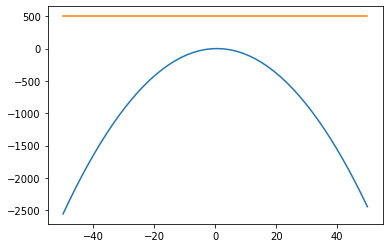

In [48]:
#VIsualize
x = np.linspace(-50,50)
c_of_x = helppp(x)

plt.plot(x,c_of_x)
plt.plot(x,np.ones_like(x)*500)
xlabel = 'Current'
ylabel = 'Power'

In [26]:
Power = 500

def objective_function(guess_current, *power):
    T = 600 #K
    example_concs = [1,2,3,4]
    
    V_rev = Nernst(T,example_concs)
    V_act = activation_overpotential()
    V_con = concentration_overpotential()
    V_ohm = ohmic_losses(guess_current)

    Vs = V_rev, V_act, V_con, V_ohm
    V = effective_cell_voltage(Vs)

    return power - guess_current*V

current_maybe = least_squares(objective_function, [-1000,100],args=([Power]))
# print('Calculated current is %.4f'%(current_maybe.x[0]))
print(current_maybe.x )
print('yay it matches above!')

[0.54597975 0.54615048]
yay it matches above!


depending on what we want, we could also have a function that minimizes (maximizes? idk is it supposed to be negative?/ confused)ohmic losses based on the possible currents that would work for our desired power. 

In [47]:
def minimize_ohmic_losses(possible_currents):
    '''
    pass me the least_squares solution array from the 
    get_current_from_power function and I will tell you
    which one gives minimum ohmic losses
    '''
    losses = ohmic_losses(possible_currents)
    min_ohmic_loss = np.min(losses)
    index = np.argmin(losses)
    corresponding_current = possible_currents[index]
    return min_ohmic_loss, corresponding_current

answer = minimize_ohmic_losses(current_maybe.x)
print('minimum ohmic loss for your power setting of %d watts (units?) is %.1f volts(?) at a current of %.2f amps(units?)'%(Power, *answer))

minimum ohmic loss for your power setting of 500 watts (units?) is 0.5 volts(?) at a current of 0.55 amps(units?)


## Simplifying for now 

In [71]:
E0_C = 0.401 #V vs SHE
E0_A = -.763 #V vs SHE
V_cell = E0_C - E0_A
# C_O2 = .21/22.4/1000 #mol O2 per cm^3
C_O2_paper = .008452 #mol/dm^3
C_O2 = C_O2_paper/1000 #mol/cm^3

#The relationship between k_f (cm/s) and Voltage (V) from kinetics proj.
k_f = 6e-5 * np.exp(4.7921*V_cell) #cm/s

i_k_amps = F*k_f*C_O2 # [C/mol * cm/s * mol/cm^3 = C/s-cm^2] = amps/cm^2
i_k_mA = i_k_amps*1000
i_k = i_k_mA

P = 1000 #kW
A_required = P*(F*k_f*C_O2*V_cell)**(-1) #cm^2
A_required

66371.01417240556